# Quantum Kernel Machine Learning

## Overview

The general task of machine learning is to find and study patterns in data. For many datasets, the datapoints are better understood in a higher dimensional feature space. This is the fundamental principle behind a series of machine learning algorithms known as *kernel methods*.

In this notebook, you will learn how to define quantum kernels using `qiskit-machine-learning` and how these can be plugged into different algorithms to solve classification and clustering problems.

All examples used in this tutorial are based on this reference paper: [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf).

The content is structured as follows:

1. [Introduction](#1.-Introduction)
2. [Classification](#2.-Classification)
3. [Clustering](#3.-Clustering)
4. [Kernel Principal Components Analysis](#4.-Kernel-Principal-Component-Analysis)
5. [Conclusion](#5.-Conclusion)

## 1. Introduction

### 1.1. Kernel Methods for Machine Learning

Kernel methods are a collection of pattern analysis algorithms that use kernel functions to operate in a high-dimensional feature space. The best-known application of kernel methods is in **Support Vector Machines (SVMs)**, supervised learning algorithms commonly used for classification tasks. The main goal of SVMs is to find decision boundaries to separate a given set of data points into classes. When these data spaces are not linearly separable, SVMs can benefit from the use of kernels to find these boundaries.

Formally, decision boundaries are hyperplanes in a high dimensional space. The kernel function implicitly maps input data into this higher dimensional space, where it can be easier to solve the initial problem. In other words, kernels may allow data distributions that were originally non-linearly separable to become a linearly separable problem. This is an effect known as the "kernel trick".

There are use-cases for kernel-based unsupervised algorithms too, for example, in the context of clustering. **Spectral Clustering** is a technique where data points are treated as nodes of a graph, and the clustering task is viewed as a graph partitioning problem where nodes are mapped to a space where they can be easily segregated to form clusters.

### 1.2. Kernel Functions

Mathematically, kernel functions follow:

$k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

where 
* $k$ is the kernel function
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $f$ is a map from $n$-dimension to $m$-dimension space and 
* $\langle a,b \rangle$ denotes the inner product

When considering finite data, a kernel function can be represented as a matrix: 

$K_{ij} = k(\vec{x}_i,\vec{x}_j)$.

### 1.3. Quantum Kernels

The main idea behind quantum kernel machine learning is to leverage quantum feature maps to perform the kernel trick. In this case, the quantum kernel is created by mapping a classical feature vector $\vec{x}$ to a Hilbert space using a quantum feature map $\phi(\vec{x})$. Mathematically:

$K_{ij} = \left| \langle \phi(\vec{x}_i)| \phi(\vec{x}_j) \rangle \right|^{2}$

where 
* $K_{ij}$ is the kernel matrix
* $\vec{x}_i, \vec{x}_j$ are $n$ dimensional inputs
* $\phi(\vec{x})$ is the quantum feature map
* $\left| \langle a|b \rangle \right|^{2}$ denotes the overlap of two quantum states $a$ and $b$

Quantum kernels can be plugged into common classical kernel learning algorithms such as SVMs or clustering algorithms, as you will see in the examples below. They can also be leveraged in new quantum kernel methods like [QSVC](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.QSVC.html) class  provided by `qiskit-machine-learning` which is explored in this tutorial, and other methods as shown in later tutorials on [Pegasos QSVC](07_pegasos_qsvc.ipynb) and [Quantum Kernel Training](08_quantum_kernel_trainer.ipynb).

***

Before introducing any example, we set up the global seed to ensure reproducibility:

In [15]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 12345

## 2. Classification

This section illustrates a quantum kernel classification workflow using `qiskit-machine-learning`.

### 2.1. Defining the dataset

For this example, we will use the _ad hoc dataset_ as described in the reference [paper](https://arxiv.org/pdf/1804.11326.pdf). 

We can define the dataset dimension and get our train and test subsets:

In [16]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris()
X = iris.data
y = iris.target
X.shape[1]

4

In [17]:
X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1
# y_2d = y

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
# grid.best_estimator_.score(X_test, y_test)

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


1.0

In [20]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

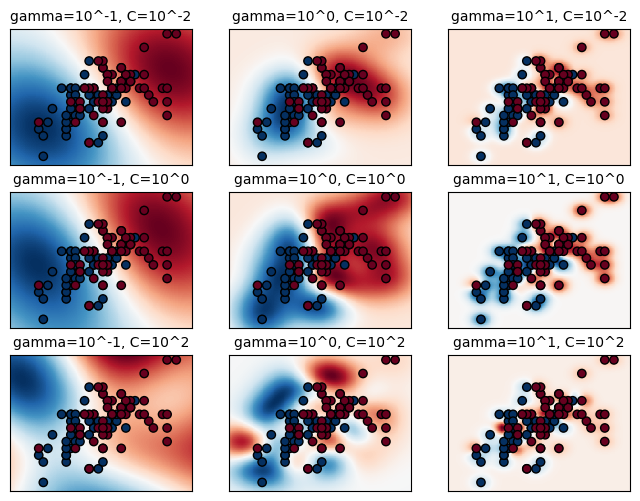

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for k, (C, gamma, clf) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

In [22]:
import numpy as np
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

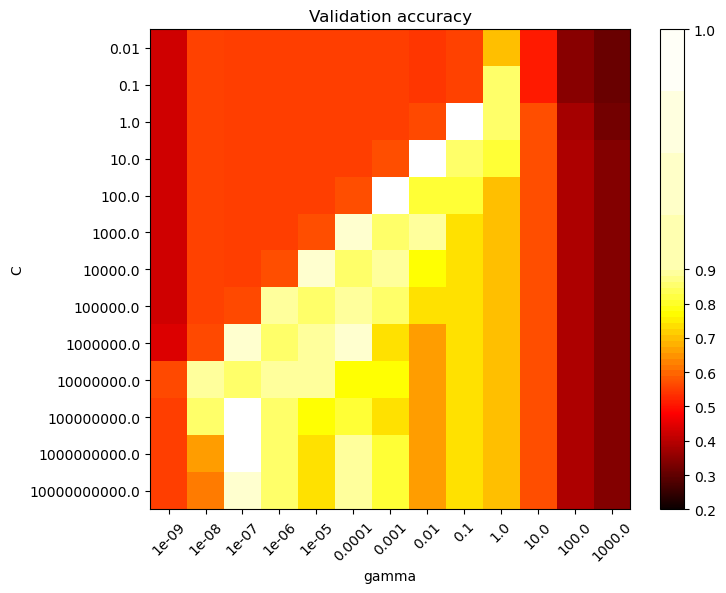

In [23]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.90),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)

plt.title("Validation accuracy")
plt.show()

This dataset is two-dimensional, the two features are represented by the $x$ and $y$ coordinates, and it has two class labels: A and B. We can plot it and see what the distribution looks like. We define utility functions to plot the dataset.

In [24]:
# import matplotlib.pyplot as plt
# import numpy as np


# def plot_features(ax, features, labels, class_label, marker, face, edge, label):
#     # A train plot
#     ax.scatter(
#         # x coordinate of labels where class is class_label
#         features[np.where(labels[:] == class_label), 0],
#         # y coordinate of labels where class is class_label
#         features[np.where(labels[:] == class_label), 1],
#         marker=marker,
#         facecolors=face,
#         edgecolors=edge,
#         label=label,
#     )


# def plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):

#     plt.figure(figsize=(5, 5))
#     plt.ylim(0, 2 * np.pi)
#     plt.xlim(0, 2 * np.pi)
#     plt.imshow(
#         np.asmatrix(adhoc_total).T,
#         interpolation="nearest",
#         origin="lower",
#         cmap="RdBu",
#         extent=[0, 2 * np.pi, 0, 2 * np.pi],
#     )

#     # A train plot
#     plot_features(plt, train_features, train_labels, 0, "s", "w", "b", "A train")

#     # B train plot
#     plot_features(plt, train_features, train_labels, 1, "o", "w", "r", "B train")

#     # A test plot
#     plot_features(plt, test_features, test_labels, 0, "s", "b", "w", "A test")

#     # B test plot
#     plot_features(plt, test_features, test_labels, 1, "o", "r", "w", "B test")

#     plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
#     plt.title("Ad hoc dataset")

#     plt.show()

Now we actually plot the dataset for classification:

In [26]:
# plot_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

In [47]:
from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = X.shape[1]
# train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
#     training_size=80,
#     test_size=20,
#     n=adhoc_dimension-2,
#     gap=0.3,
#     plot_data=False,
#     one_hot=False,
#     include_sample_total=True,
# )
# test_labels.shape

(40,)

### 2.2. Defining the quantum kernel

The next step is to create a quantum kernel instance that will help classify this data. 

We use the [FidelityQuantumKernel](https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html) class, and pass two input arguments to its constructor: 

1. `feature_map`: in this case, a two-qubit [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).

2. `fidelity`: in this case, the [ComputeUncompute](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.state_fidelities.ComputeUncompute.html) fidelity subroutine that leverages the [Sampler](https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Sampler) primitive.

**NOTE:** If you don't pass a `Sampler` or `Fidelity` instance, then the instances of the reference `Sampler` and `ComputeUncompute` classes (found in `qiskit.primitives`) will be created by default.

In [67]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=5, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

adhoc_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=adhoc_feature_map)

### 2.3. Classification with SVC
The quantum kernel can now be plugged into classical kernel methods, such as the [SVC](https://scikit-learn.org/stable/modules/svm.html) algorithm from `scikit-learn`. This algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways:

1. by providing the kernel as a **callable function**
2. by precomputing the **kernel matrix**

#### Kernel as a callable function

We define a SVC model and directly pass the `evaluate` function of the quantum kernel as a callable. Once the model is created, we train it by calling the `fit` method on the training dataset and evaluate the model for accuracy with `score`.

In [52]:
from sklearn.svm import SVC

adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

adhoc_svc.fit(X_train, y_train)

adhoc_score_callable_function = adhoc_svc.score(X_test, y_test)

print(f"Callable kernel classification test score: {adhoc_score_callable_function}")

Callable kernel classification test score: 0.5333333333333333


#### Precomputed kernel matrix

Instead of passing a function of the quantum kernel as a callable, we can also precompute training and testing kernel matrices before passing them to the `scikit-learn` `SVC` algorithm. 

To extract the train and test matrices, we can call `evaluate` on the previously defined kernel and visualize them graphically as follows:

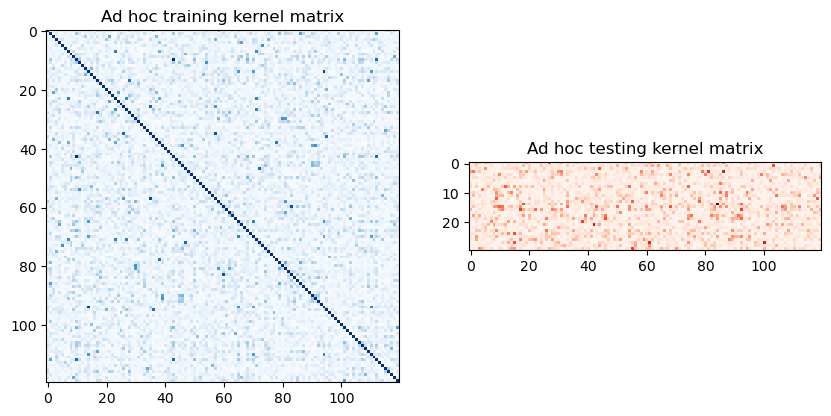

In [53]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=X_train)
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(adhoc_matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")

axs[1].imshow(np.asmatrix(adhoc_matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")

plt.show()

To use these matrices, we set the `kernel` parameter of a new `SVC` instance to `"precomputed"`. We train the classifier by calling `fit` with the training matrix and training dataset. Once the model is trained, we evaluate it using the test matrix on the test dataset.

In [59]:
adhoc_svc = SVC(kernel="precomputed", C=100000, gamma=0.1)

adhoc_svc.fit(adhoc_matrix_train, y_train)

adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, y_test)

print(f"Precomputed kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed kernel classification test score: 0.6333333333333333


In [29]:
# svc = SVC()

# svc.fit(adhoc_matrix_train, train_labels)

# svc_classical_score = svc.score(adhoc_matrix_test, test_labels)
# print(f"Classical SVM classification test score: {svc_classical_score}")

### 2.4. Classification with QSVC

`QSVC` is an alternative training algorithm provided by `qiskit-machine-learning` for convenience. It is an extension of `SVC` that takes in a quantum kernel instead of the `kernel.evaluate` method shown before.

In [68]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=adhoc_kernel, C=100, gamma=5)

# qsvc.fit(train_features, train_labels)
qsvc.fit(X_train, y_train)

qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.36666666666666664


#### Grid Search

In [61]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(kernel='precomputed'), param_grid=param_grid, cv=cv)
grid.fit(adhoc_matrix_train, y_train)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'gamma': 1e-09} with a score of 0.48


### 2.5. Evaluation of models used for classification

In [36]:
print(f"Classification Model                    | Accuracy Score")
print(f"---------------------------------------------------------")
# print(f"SVC using kernel as a callable function | {adhoc_score_callable_function:10.2f}")
# print(f"SVC using precomputed kernel matrix     | {adhoc_score_precomputed_kernel:10.2f}")
print(f"QSVC                                    | {qsvc_score:10.2f}")

Classification Model                    | Accuracy Score
---------------------------------------------------------
QSVC                                    |       1.00


As the classification dataset is small, we find that the three models achieve 100% accuracy.

## 5. Conclusion

In this tutorial:

* We reviewed the fundamentals of quantum kernel learning
* We understood how to define quantum kernels as instances of `FidelityQuantumKernel`
* We learned how to use the `scikit-learn` `SVC` algorithm with a custom quantum kernel as a callable function vs precomputed quantum kernel matrix for classification
* We learned how to train classifiers with the `QSVC` algorithm from `qiskit-machine-learning`
* We learned how to use the `scikit-learn` `SpectralClustering` algorithms with a precomputed quantum kernel matrix for clustering
* We investigated how to plug in a quantum kernel into `scikit-learn`'s `KernelPCA` algorithm and transform the ad-hoc dataset into a new one that can be tackled by a linear model.

For further reference, `scikit-learn` has other algorithms that can use a precomputed kernel matrix, such as:

- [Agglomerative clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)
- [Support vector regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
- [Gaussian process regression](https://scikit-learn.org/stable/modules/gaussian_process.html)

In [34]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright

ModuleNotFoundError: No module named 'tutorial_magics'